In [33]:
from langchain.chat_models import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
import matplotlib.pyplot as plt
import random
import json
from dotenv import load_dotenv
import os
from tqdm import tqdm
import time
import networkx as nx
load_dotenv() 

True

Let's try to chain this thing

In [63]:
with open("prompt_v2.txt", 'r') as f:
    prompt = HumanMessage(f.read())

history = [prompt]

In [16]:
gen_model = ChatOpenAI(model="gpt-4o-mini", api_key=os.getenv("OPENAI_API_KEY"), base_url=os.getenv("OPENAI_BASE_URL"), temperature=0)
check_model = ChatOpenAI(model="gpt-4o-mini", api_key=os.getenv("OPENAI_API_KEY"), base_url=os.getenv("OPENAI_BASE_URL"), temperature=0)

fill_graph_prompt = ChatPromptTemplate.from_template("tell me a joke about {topic}")
check_triplet_prompt = ChatPromptTemplate.from_template("decide if the triplet is valid. triplet: {triplet}")

In [64]:
def generate_dialogue_graph_pair():
    response = gen_model.invoke(history)
    try:
        return json.loads(response.content)
    except json.JSONDecodeError:
        print("Error: Invalid JSON response. Retrying...")
        return None

In [65]:
results = []
for i in tqdm(range(10)):
    pair = None
    while pair is None:
        pair = generate_dialogue_graph_pair()
        if pair is not None:
            pair['id'] = i + 1
            results.append(pair)
        else:
            print("Invalid JSON.")
    time.sleep(1)  # Add a small delay between requests to avoid rate limiting

with open('dialogue_graph_pairs.json', 'w') as f:
    json.dump(results, f, indent=2)

print("Generation complete. Results saved to dialogue_graph_pairs.json")

100%|██████████| 10/10 [01:36<00:00,  9.66s/it]

Generation complete. Results saved to dialogue_graph_pairs.json


In [29]:
def visualize_graph(graph, title):
    G = nx.DiGraph()
    for node in graph["nodes"]:
        G.add_node(node["id"], label=node["label"])
    for edge in graph["edges"]:
        G.add_edge(edge["source"], edge["target"], label=edge["utterances"])

    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color="lightblue", node_size=500, font_size=8, arrows=True)
    edge_labels = nx.get_edge_attributes(G, "label")
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6)
    plt.title(title)
    plt.axis("off")

In [66]:
with open('dialogue_graph_pairs.json', 'r') as f:
    graphs = json.load(f)

In [61]:
def dialogues_from_graph(graph):
    # Create a directed graph from the JSON input
    G = nx.DiGraph()
    
    # Add nodes and edges to the graph
    for node in graph['nodes']:
        # Ensure 'is_start' is included in the node attributes
        G.add_node(node['id'], label=node['label'], utterances=node['utterances'], is_start=node.get('is_start', False))
    
    for edge in graph['edges']:
        G.add_edge(edge['source'], edge['target'], utterances=edge['utterances'])
    
    # Start the dialogue from the starting node
    start_nodes = [node for node in G.nodes if G.nodes[node].get('is_start', True)]
    if not start_nodes:
        raise ValueError("No starting node found in the graph.")
    
    current_node = random.choice(start_nodes)  # Randomly select one of the starting nodes
    dialogue = []
    visited_nodes = set()  # Track visited nodes to prevent cycles
    
    # Generate a dialogue by traversing the graph
    while True:
        # Get the current node's utterances
        node_utterances = G.nodes[current_node]['utterances']
        print("NODE:", node_utterances)
        dialogue.append(random.choice(node_utterances))  # Randomly select an utterance
        
        # Mark the current node as visited
        visited_nodes.add(current_node)
        
        # Get the next possible nodes to traverse
        next_nodes = list(G.successors(current_node))
        if not next_nodes:  # If there are no successors, break the loop
            break
        
        # Filter out already visited nodes to prevent cycles
        next_nodes = [node for node in next_nodes if node not in visited_nodes]
        if not next_nodes:  # If all next nodes have been visited, break the loop
            break
        
        next_node = random.choice(next_nodes)
        
        # Get the edge utterances between the current node and the next node
        edge_utterances = G[current_node][next_node]['utterances']
        print("EDGE:", edge_utterances)
        dialogue.append(random.choice(edge_utterances)) 
        # Randomly select the next node to traverse
        current_node = next_node
    
    return dialogue

In [73]:
dialogues_from_graph(graphs[1])

NODE: ['How can I assist you today?', 'Welcome! What can I do for you?']
EDGE: ['I want to book a flight.', 'Can you help me with a flight reservation?']
NODE: ['Where would you like to fly to?']
EDGE: ['I would like to fly from New York to London.', 'I need a ticket from Los Angeles to Tokyo.']
NODE: ['What time of day do you prefer to fly?']
EDGE: ['I prefer a morning flight.', 'An evening flight would be great.']
NODE: ['Would you like to try a different flight option?']


['How can I assist you today?',
 'Can you help me with a flight reservation?',
 'Where would you like to fly to?',
 'I need a ticket from Los Angeles to Tokyo.',
 'What time of day do you prefer to fly?',
 'An evening flight would be great.',
 'Would you like to try a different flight option?']

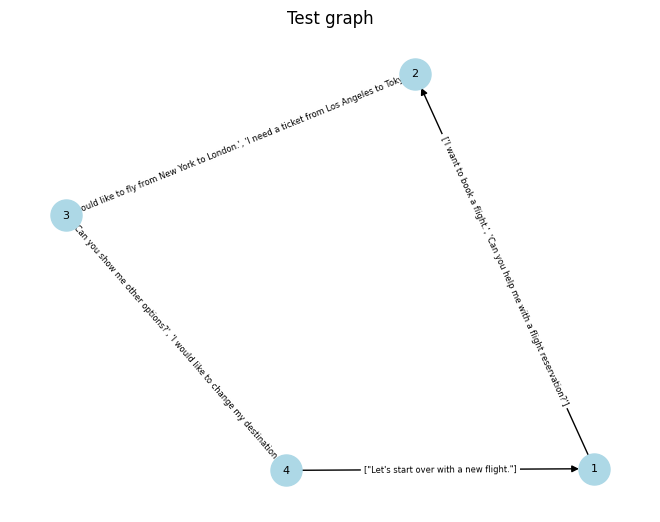

In [74]:
visualize_graph(graphs[1], "Test graph")
